In [1]:
# Load & aggregate
from pathlib import Path
import subprocess, sys, re
import pandas as pd
import numpy as np

def find_tables_dir():
    # Try common locations relative to the notebook
    for d in [Path("../results/tables"), Path("results/tables"), Path("../../results/tables")]:
        if d.exists():
            return d
    # If no tables dir, assume repo root is one level up and create it
    root = Path("..")
    (root / "results" / "tables").mkdir(parents=True, exist_ok=True)
    return root / "results" / "tables"

TABLES = find_tables_dir()
print("TABLES =", TABLES.resolve())

# discover files; if none, create a few quick ones so the rest of the notebook works
files = sorted(TABLES.glob("nullcal_*_p*.csv"))
print("Found", len(files), "nullcal_* files")
if not files:
    repo_root = TABLES.parent.parent
    cmds = [
        [sys.executable, "-m", "scripts.run_null_calibration", "--p", "250", "--reps", "5", "--B", "50,100", "--n-jobs", "1"],
        [sys.executable, "-m", "scripts.run_null_calibration", "--p", "500", "--reps", "5", "--B", "50,100", "--n-jobs", "1"],
    ]
    for cmd in cmds:
        print("Running:", " ".join(cmd))
        subprocess.run(cmd, cwd=repo_root, check=False)
    files = sorted(TABLES.glob("nullcal_*_p*.csv"))
    print("Now found", len(files), "files")

# Load whatever exists; if still empty, keep df as empty frame
df = pd.concat([pd.read_csv(f).assign(file=f.name) for f in files], ignore_index=True) if files else pd.DataFrame()
print("df shape:", df.shape)
df.head()

TABLES = C:\Users\hirshikesh\Desktop\lct-corr-replication\results\tables
Found 8 nullcal_* files
df shape: (400, 61)


,model,p,n1,n2,seed,t_lct_0.05,R_lct_0.05,fdp_lct_0.05,any_reject_lct_0.05,R_over_M_lct_0.05,...,any_reject_lctb_0.05_B500,R_over_M_lctb_0.05_B500,t_lctb_0.10_B500,R_lctb_0.10_B500,fdp_lctb_0.10_B500,any_reject_lctb_0.10_B500,R_over_M_lctb_0.10_B500,lctb_B500_wall_time_s,wall_time_s,file
0,exp,250,80,80,0,1.810879,0,0.0,0,0.0,...,0,0.0,1.810879,0,0.0,0,0.0,5.180351,19.452584,nullcal_exp_p250_n80_80_R50.csv
1,exp,250,80,80,1,1.941078,0,0.0,0,0.0,...,0,0.0,1.941078,0,0.0,0,0.0,5.166102,19.441782,nullcal_exp_p250_n80_80_R50.csv
2,exp,250,80,80,2,1.743907,0,0.0,0,0.0,...,0,0.0,1.743907,0,0.0,0,0.0,5.159965,19.387307,nullcal_exp_p250_n80_80_R50.csv
3,exp,250,80,80,3,1.795669,0,0.0,0,0.0,...,0,0.0,1.795669,0,0.0,0,0.0,5.188823,19.472988,nullcal_exp_p250_n80_80_R50.csv
4,exp,250,80,80,4,1.822871,0,0.0,0,0.0,...,0,0.0,1.822871,0,0.0,0,0.0,5.192586,19.478985,nullcal_exp_p250_n80_80_R50.csv


,file,alpha,B,mean,se
0,nullcal_exp_p250_n80_80_R50.csv,0.05,50,0.0,0.0
1,nullcal_exp_p250_n80_80_R50.csv,0.05,100,0.0,0.0
2,nullcal_exp_p250_n80_80_R50.csv,0.05,200,0.0,0.0
3,nullcal_exp_p250_n80_80_R50.csv,0.05,500,0.0,0.0
4,nullcal_exp_p250_n80_80_R50.csv,0.10,50,0.0,0.0


,file,alpha,B,any_reject_rate
0,nullcal_exp_p250_n80_80_R50.csv,0.05,50,0.0
1,nullcal_exp_p250_n80_80_R50.csv,0.05,100,0.0
2,nullcal_exp_p250_n80_80_R50.csv,0.05,200,0.0
3,nullcal_exp_p250_n80_80_R50.csv,0.05,500,0.0
4,nullcal_exp_p250_n80_80_R50.csv,0.10,50,0.0


,file,B,sec
0,nullcal_exp_p250_n80_80_R50.csv,50,3.006524
1,nullcal_exp_p250_n80_80_R50.csv,100,3.278677
2,nullcal_exp_p250_n80_80_R50.csv,200,3.763347
3,nullcal_exp_p250_n80_80_R50.csv,500,5.192826
4,nullcal_exp_p500_n80_80_R50.csv,50,44.021821


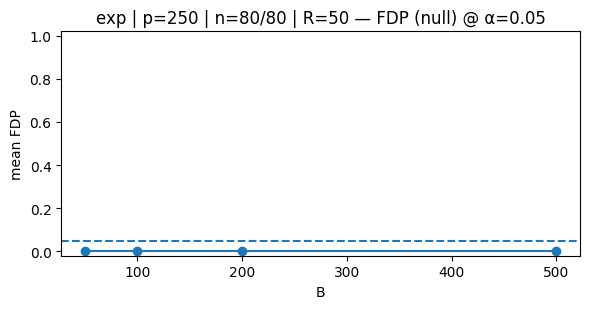

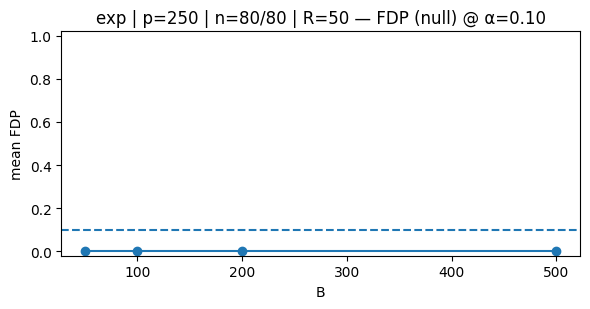

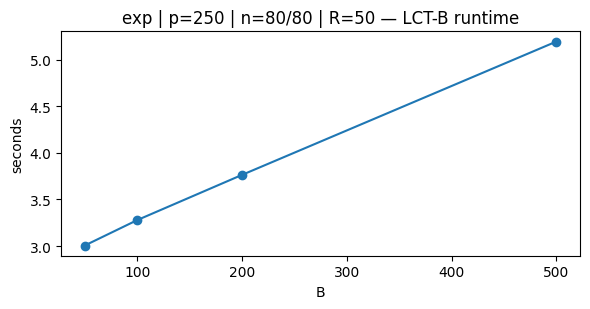

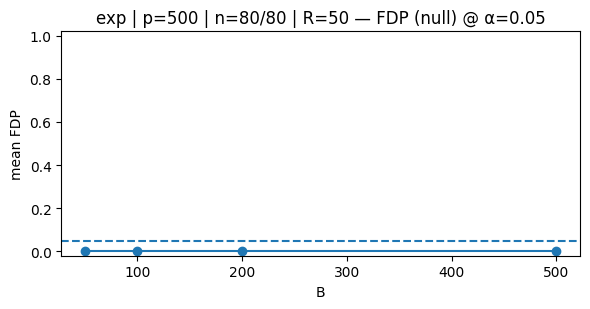

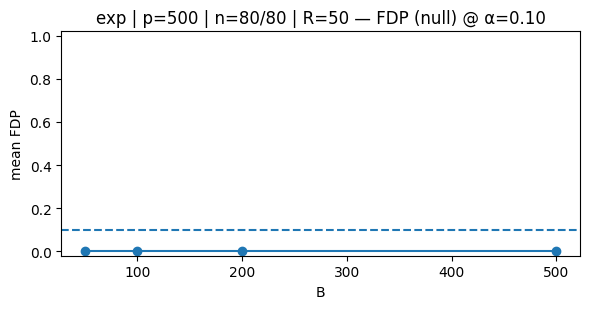

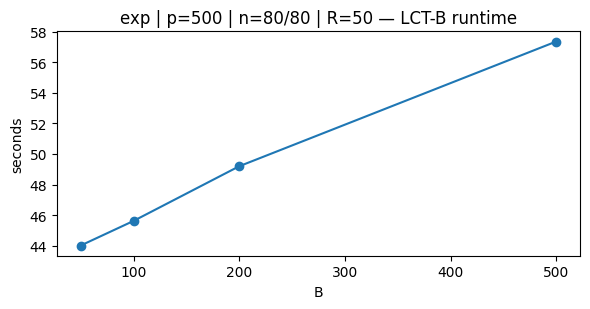

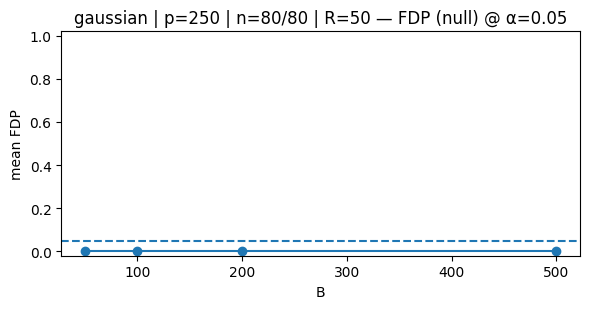

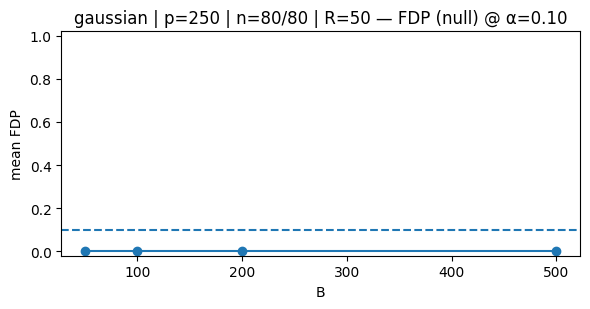

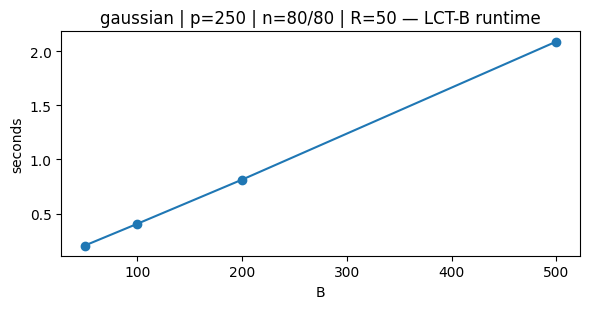

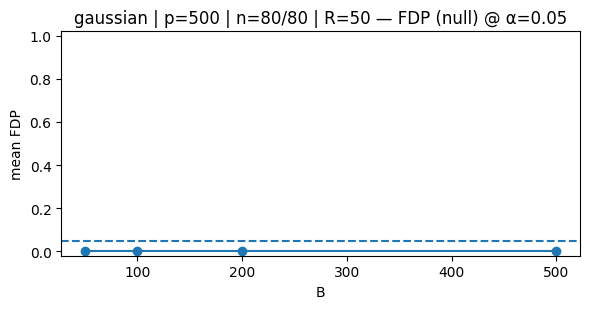

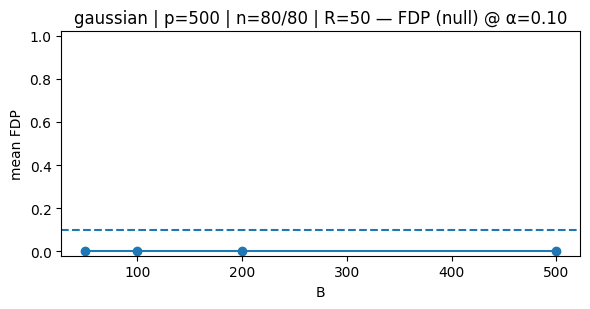

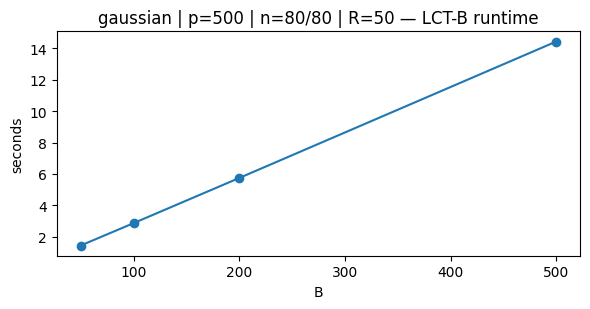

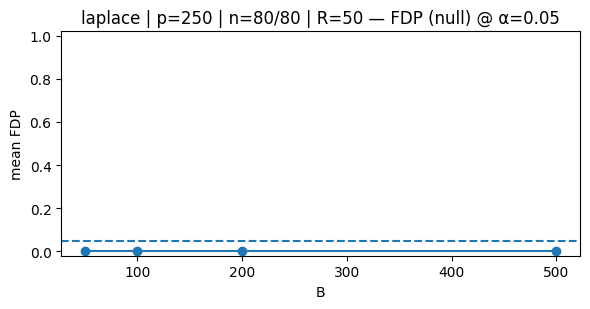

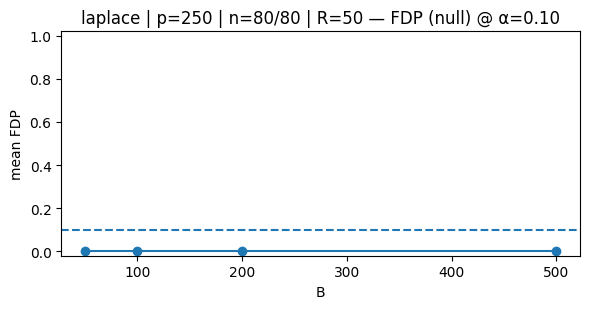

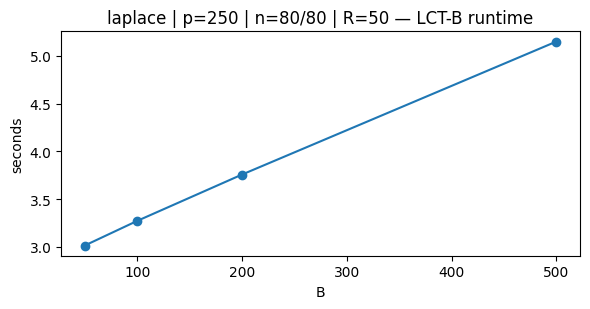

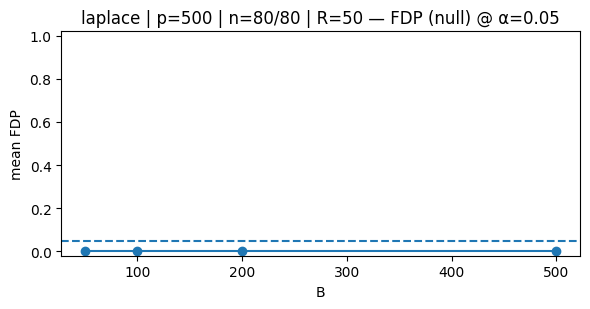

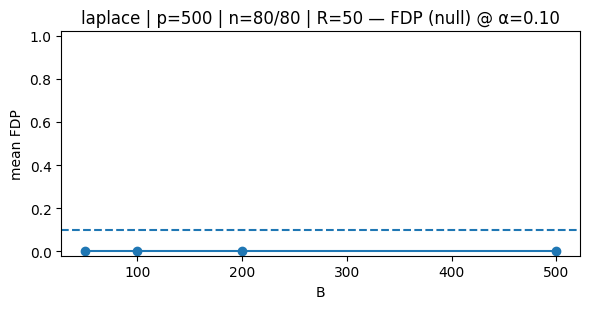

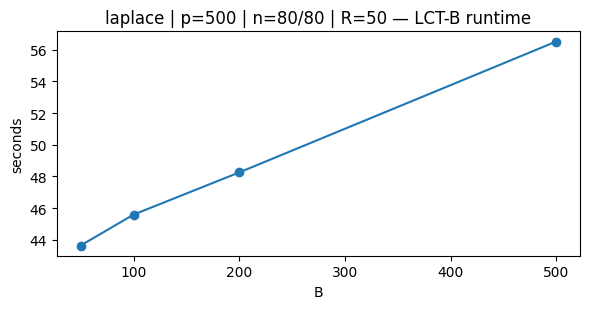

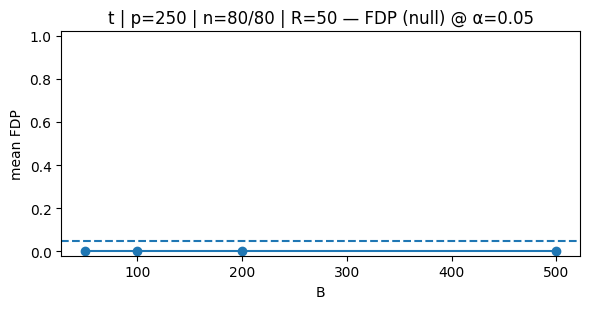

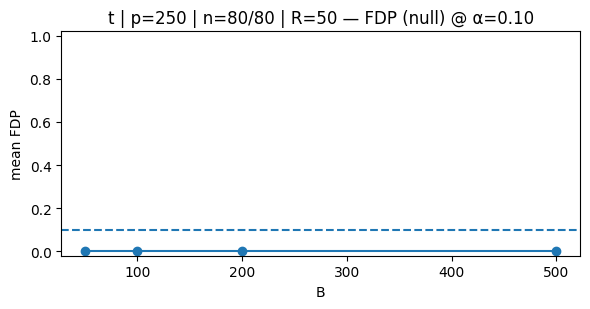

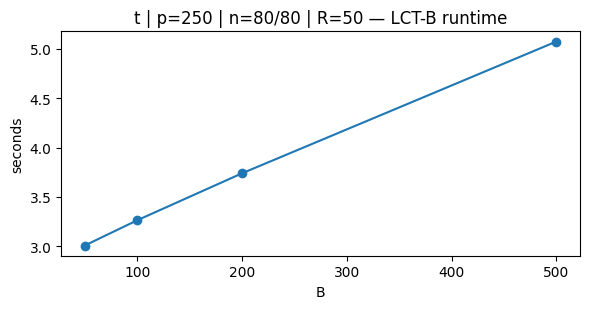

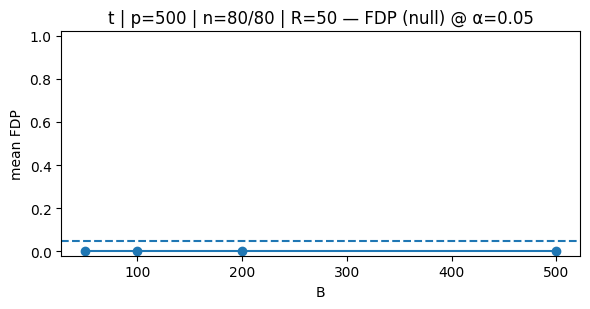

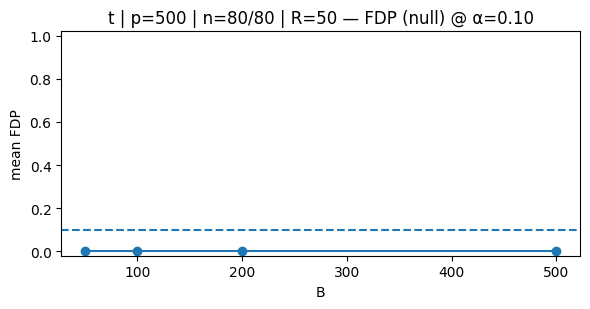

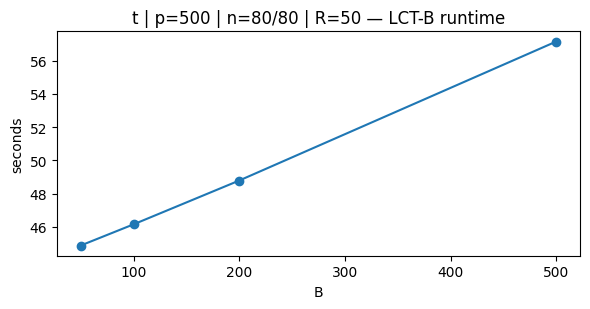

In [2]:
# Plots: FDP vs B and runtime vs B
import matplotlib.pyplot as plt

def melt_metric(df, prefix):
    cols = [c for c in df.columns if isinstance(c, str) and c.startswith(prefix)]
    if not cols:
        # return an empty frame with expected columns so downstream code won't error
        return pd.DataFrame(columns=[*(c for c in df.columns if c not in []), "metric", "val"])
    return df.melt(id_vars=[c for c in df.columns if c not in cols],
                   value_vars=cols, var_name="metric", value_name="val")

def parse_alpha(metric):
    s = str(metric)
    m = re.search(r'_(0\.05|0\.10)', s)
    return m.group(1) if m else None

def parse_B(metric):
    s = str(metric)
    m = re.search(r'_B(\d+)', s)
    return int(m.group(1)) if m else None

# ---- long tables ----
long_fdp = melt_metric(df, "fdp_lctb_")
long_any = melt_metric(df, "any_reject_lctb_")
rt_cols = [c for c in df.columns if isinstance(c, str) and c.startswith("lctb_B") and c.endswith("_wall_time_s")]

if len(long_fdp):
    long_fdp["alpha"] = long_fdp["metric"].apply(parse_alpha)
    long_fdp["B"] = long_fdp["metric"].apply(parse_B)
    long_fdp = long_fdp.dropna(subset=["alpha","B"])
    agg_fdp = (long_fdp.groupby(["file","alpha","B"])["val"]
                        .agg(mean="mean", se=lambda x: x.std(ddof=1)/max(len(x),1)**0.5)
                        .reset_index())
else:
    agg_fdp = pd.DataFrame(columns=["file","alpha","B","mean","se"])

if len(long_any):
    long_any["alpha"] = long_any["metric"].apply(parse_alpha)
    long_any["B"] = long_any["metric"].apply(parse_B)
    agg_any = long_any.groupby(["file","alpha","B"])["val"].mean().reset_index(name="any_reject_rate")
else:
    agg_any = pd.DataFrame(columns=["file","alpha","B","any_reject_rate"])

if rt_cols:
    rt_long = df.melt(id_vars=["file"], value_vars=rt_cols, var_name="metric", value_name="sec")
    rt_long["B"] = rt_long["metric"].str.extract(r'B(\d+)', expand=False).astype(int)
    rt_agg = rt_long.groupby(["file","B"])["sec"].mean().reset_index()
else:
    rt_agg = pd.DataFrame(columns=["file","B","sec"])

display(agg_fdp.head())
display(agg_any.head())
display(rt_agg.head())

# ---- Plots (only if we have data) ----
def nice_title(file):
    m = re.search(r'nullcal_(\w+)_p(\d+)_n(\d+)_(\d+)_R(\d+)\.csv', file)
    return f"{m.group(1)} | p={m.group(2)} | n={m.group(3)}/{m.group(4)} | R={m.group(5)}" if m else file

if not agg_fdp.empty:
    for file in sorted(agg_fdp["file"].unique()):
        title = nice_title(file)
        a = agg_fdp[agg_fdp["file"]==file]
        r = rt_agg[rt_agg["file"]==file]
        for alpha in sorted(a["alpha"].unique()):
            sub = a[a["alpha"]==alpha].sort_values("B")
            plt.figure(figsize=(6,3.2))
            plt.errorbar(sub["B"], sub["mean"], yerr=sub["se"], fmt="-o")
            plt.axhline(0.05 if alpha=="0.05" else 0.10, linestyle="--")
            plt.ylim(-0.02, 1.02)
            plt.title(f"{title} — FDP (null) @ α={alpha}")
            plt.xlabel("B"); plt.ylabel("mean FDP")
            plt.tight_layout(); plt.show()
        if not r.empty:
            plt.figure(figsize=(6,3.2))
            rr = r.sort_values("B")
            plt.plot(rr["B"], rr["sec"], "-o")
            plt.title(f"{title} — LCT-B runtime")
            plt.xlabel("B"); plt.ylabel("seconds")
            plt.tight_layout(); plt.show()
else:
    print("No calibration data found in", TABLES, "— run the calibration script first.")